In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 50000
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy")
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    #V_pad = np.zeros_like(V)
    #V_pad[:,i+1:] = V[:,:-i-1]
    #V_lag[:,:,i] = V - V_pad
    
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [7]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_V_lag = V_lag_train[batch_idx].to(device)[:,part_time_idx]
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in[:,part_time_idx])
        test_loss = bce_criterion(test_S_out, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-7-37596d4407d9>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.7181244492530823
49 0.006293756887316704
99 0.0031056494917720556
149 0.0021654199808835983
199 0.0016619411762803793
249 0.0013444372452795506
299 0.0011317967437207699
349 0.000976809300482273
399 0.0008688991074450314
449 0.0007852801936678588
499 0.0007185504073277116
549 0.0006637799087911844
599 0.0006141686462797225
649 0.0005565264145843685
699 0.0005160192376933992
749 0.00048091504140757024
799 0.00045297370525076985
849 0.00042770319851115346
899 0.0004062236112076789
949 0.0003871997760143131
999 0.00036990540684200823
1049 0.00035410115378908813
1099 0.0003378696274012327
1149 0.00031398035935126245
1199 0.000302808650303632
1249 0.00029084717971272767
1299 0.0002809993748087436
1349 0.00027203455101698637
1399 0.000263587455265224
1449 0.0002547052863519639
1499 0.0002467572339810431
1549 0.00022589584114030004
1599 0.00021659985941369087
1649 0.0002093880611937493
1699 0.00020349444821476936
1749 0.00019602706015575677
1799 0.00019019132014364004
1849 0.0001843186037

KeyboardInterrupt: 

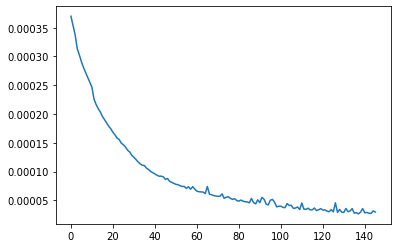

In [10]:
plt.plot(np.asarray(score_list)[20:])

(23000.0, 26000.0)

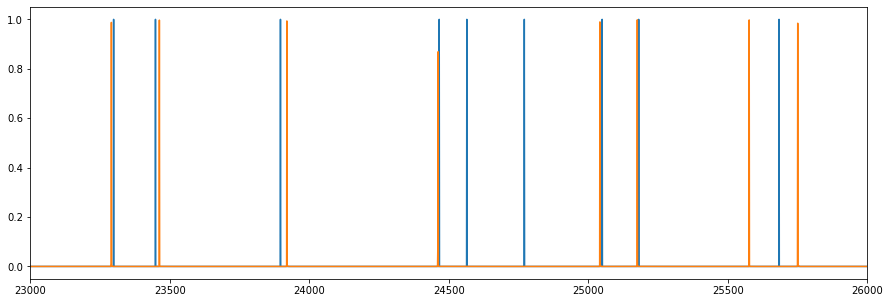

In [12]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [13]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_test.npy", test_S_out.cpu().detach().numpy())